In [145]:
from scipy.spatial.transform import Rotation as R
import subprocess
import matplotlib.pyplot as plot
import numpy
import sys
from optparse import OptionParser
import math
import copy
import random
now_meeted_robot = ['robot1']
self_robot_name = ['robot2']
name_list = self_robot_name + now_meeted_robot
input = [['robot2', 'robot1', [-2.1477380774665837, -1.3380744416578318, -155.18634882486091], [3.8103106021881104, -7.006240367889404, 6.280696868896484], [0.04713878270121127, -0.002289754169865292, -167.79749326316235]], ['robot2', 'robot1', [-0.7236304057178752, 2.4234148431909848, 117.95204247652624], [5.7761125564575195, -3.3700857162475586, 108.77442932128906], [-0.2936877093603366, 0.05595260826498958, -136.0370774435186]], ['robot2', 'robot1', [-4.373522084944867, -2.536801070112964, -162.78845798352333], [1.318068504333496, -7.2258992195129395, -49.161834716796875], [0.4927558688631841, 0.04500386646050251, -74.42542557272863]]]

new_input = []
init_guess_center = [-7,7,30]
for now_input in input:
    now_vertex = now_input[3]
    tmp = []
    theta = init_guess_center[2]/180*math.pi
    tmp.append(math.cos(theta) * now_vertex[0] - math.sin(theta) * now_vertex[1] + init_guess_center[0])
    tmp.append(math.sin(theta) * now_vertex[0] + math.cos(theta) * now_vertex[1] + init_guess_center[1])
    tmp.append(theta + now_vertex[2])
    now_input[3] = tmp
    new_input.append(now_input)
input = new_input
estimate_real = []

for now_input in input:
    now_est = now_input[4]
    tmp = []
    theta = now_input[2][2]/180*math.pi
    tmp.append(math.cos(theta) * now_est[0] - math.sin(theta) * now_est[1] + now_input[3][0])
    tmp.append(math.sin(theta) * now_est[0] + math.cos(theta) * now_est[1] + now_input[3][1])
    tmp.append(theta + now_est[2])
    estimate_real.append(tmp)
estimate_real = numpy.array(estimate_real)
# now_meeted_robot = ['robot1']
# self_robot_name = ['robot2']
# name_list = self_robot_name + now_meeted_robot
# input =  [['robot2', 'robot1', [-0.0011728304364084386, 0.003723924394819929, 0.05933554019269594], [-0.003479321487247944, 0.0015267840353772044, -0.03461313620209694], [0.544768604965521, -0.8986373766179356, 29.302346582113138]]]
pose_origin1 = numpy.array([],float).reshape((2,-1))
pose_origin2 = numpy.array([],float).reshape((2,-1))

c_real = [[0,0,0],init_guess_center]

trust1 = 1
trust2 = 100

now_id = 1
trans_data = ""
for center in c_real:
    trans_data+="VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(now_id,center[0],center[1],center[2]/180*math.pi)
    if now_id == 1:
        pose_origin1 = numpy.append(pose_origin1, numpy.array([[center[0]],[center[1]]]), axis=1)
    else:
        pose_origin2 = numpy.append(pose_origin2, numpy.array([[center[0]],[center[1]]]), axis=1)
    now_id +=1

for now_input in input:
    trans_data+="VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(now_id,now_input[2][0],now_input[2][1],now_input[2][2]/180*math.pi)
    trans_data+="VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(now_id+1,now_input[3][0],now_input[3][1],now_input[3][2]/180*math.pi)
    pose_origin1 = numpy.append(pose_origin1, numpy.array([[now_input[2][0]],[now_input[2][1]]]), axis=1)
    pose_origin2 = numpy.append(pose_origin2, numpy.array([[now_input[3][0]],[now_input[3][1]]]), axis=1)

    start_idx = str(name_list.index(now_input[0])+1)
    end_idx = str(name_list.index(now_input[1])+1)
    trans_data+="EDGE_SE2 {} {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(start_idx, now_id,now_input[2][0],now_input[2][1],now_input[2][2]/180*math.pi,trust2,trust2,trust2)
    trans_data+="EDGE_SE2 {} {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(end_idx, now_id+1,now_input[3][0],now_input[3][1],now_input[3][2]/180*math.pi,trust2,trust2,trust2)
    trans_data+="EDGE_SE2 {} {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(start_idx,end_idx,now_input[4][0],now_input[4][1],now_input[4][2]/180*math.pi,trust1,trust1,trust1)
    now_id += 2


print(trans_data)
process = subprocess.Popen("./pose_graph_2d", stdin=subprocess.PIPE, stdout=subprocess.PIPE, text=True)
# 向C++程序输入数据
process.stdin.write(trans_data)
# 关闭输入流
process.stdin.close()
output_data = process.stdout.read()
# 等待C++程序退出
process.wait()

output_data = output_data[:-1]

print(output_data)

rows = output_data.split('\n')
# 将每行分割成字符串数组
data_list = [row.split() for row in rows]
# 将字符串数组转换为浮点数数组
data_arr = numpy.array(data_list, dtype=float)
poses_optimized = data_arr[:,1:]
poses_optimized[:,-1] = poses_optimized[:,-1] / math.pi *180#转换到角度制度
print("\npose optimized \n",poses_optimized)
print(R.from_euler('z', poses_optimized[1][2], degrees=True).as_matrix())

VERTEX_SE2 1 0.000000 0.000000 0.000000
VERTEX_SE2 2 -7.000000 7.000000 0.523599
VERTEX_SE2 3 -2.147738 -1.338074 -2.708513
VERTEX_SE2 4 -0.197054 2.837573 0.118757
EDGE_SE2 1 3 -2.147738 -1.338074 -2.708513 100.000000 0 0 100.000000 0 100.000000
EDGE_SE2 2 4 -0.197054 2.837573 0.118757 100.000000 0 0 100.000000 0 100.000000
EDGE_SE2 1 2 0.047139 -0.002290 -2.928619 1.000000 0 0 1.000000 0 1.000000
VERTEX_SE2 5 -0.723630 2.423415 2.058652
VERTEX_SE2 6 -0.312697 6.969476 1.907610
EDGE_SE2 1 5 -0.723630 2.423415 2.058652 100.000000 0 0 100.000000 0 100.000000
EDGE_SE2 2 6 -0.312697 6.969476 1.907610 100.000000 0 0 100.000000 0 100.000000
EDGE_SE2 1 2 -0.293688 0.055953 -2.374295 1.000000 0 0 1.000000 0 1.000000
VERTEX_SE2 7 -4.373522 -2.536801 -2.841195
VERTEX_SE2 8 -2.245570 1.401222 -0.848897
EDGE_SE2 1 7 -4.373522 -2.536801 -2.841195 100.000000 0 0 100.000000 0 100.000000
EDGE_SE2 2 8 -2.245570 1.401222 -0.848897 100.000000 0 0 100.000000 0 100.000000
EDGE_SE2 1 2 0.492756 0.045004 -1

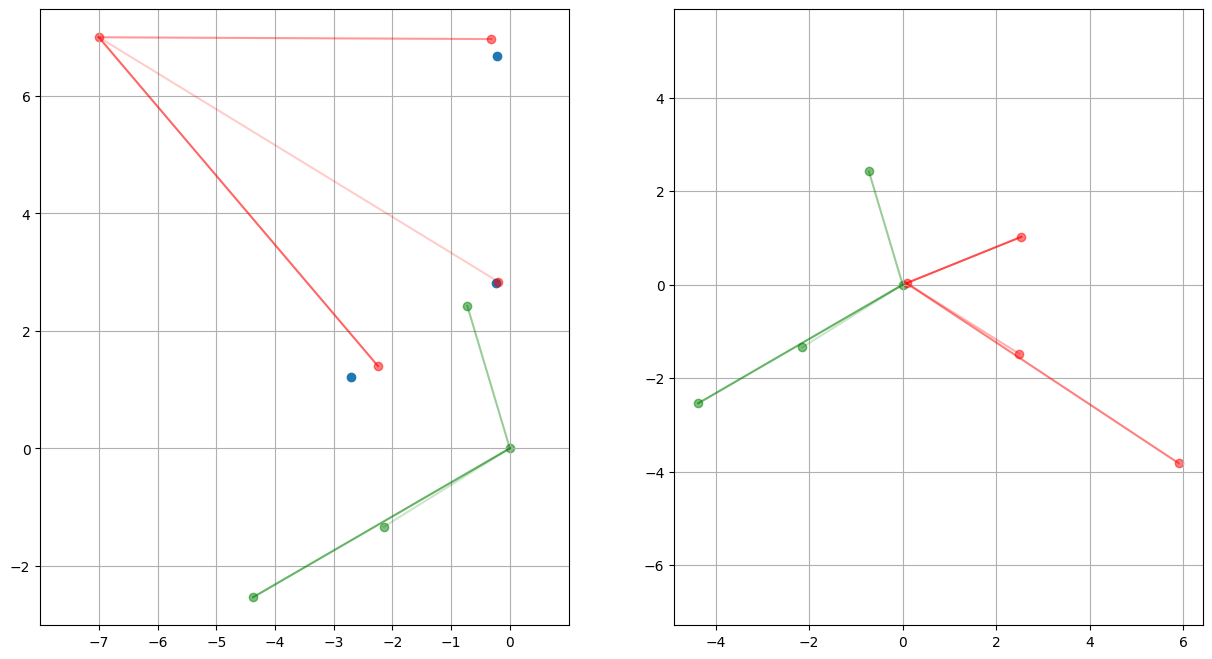

In [146]:
import matplotlib.pyplot as plot
import numpy as np
import sys

# Read the original and optimized poses files.


rows = output_data.split('\n')
# 将每行分割成字符串数组
data_list = [row.split() for row in rows]
# 将字符串数组转换为浮点数数组
data_arr = np.array(data_list, dtype=float)

poses_optimized = data_arr[:,1:-1]
# Plots the results for the specified poses.
plot.figure(figsize=(15,8))

plot.subplot(121)
plot.scatter(estimate_real[:,0],estimate_real[:,1])
plot.scatter(pose_origin1[0,:], pose_origin1[1,:],alpha=0.5, color="green")
for i in range(1,pose_origin1.shape[1]):
    plot.plot([pose_origin1[0,0],pose_origin1[0,i]], [pose_origin1[1,0],pose_origin1[1,i]],alpha=i/5, color="green")
plot.scatter(pose_origin2[0,:], pose_origin2[1,:],alpha=0.5, color="red")
for i in range(1,pose_origin2.shape[1]):
    plot.plot([pose_origin2[0,0],pose_origin2[0,i]], [pose_origin2[1,0],pose_origin2[1,i]],alpha=i/5, color="red")
plot.axis('equal')
plot.grid()

# figure2
plot.subplot(122)
plot.scatter(poses_optimized[0,0], poses_optimized[0,1],alpha=0.5, color="green")

for i in range(2,pose_origin1.shape[1]*2,2):
    plot.scatter(poses_optimized[i,0], poses_optimized[i,1],alpha=0.5, color="green")
    plot.plot([poses_optimized[0,0],poses_optimized[i,0]], [poses_optimized[0,1],poses_optimized[i,1]],alpha=i/10, color="green")

plot.scatter(poses_optimized[1,0], poses_optimized[1,1],alpha=0.5, color="red")
for i in range(3,pose_origin1.shape[1]*2,2):
    plot.scatter(poses_optimized[i,0], poses_optimized[i,1],alpha=0.5, color="red")
    plot.plot([poses_optimized[1,0],poses_optimized[i,0]], [poses_optimized[1,1],poses_optimized[i,1]],alpha=i/10, color="red")
plot.grid()
plot.axis('equal')
# Show the plot and wait for the user to close.
plot.show()
